In [1]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_gen = datagen.flow_from_directory('dogscats/train/',
                                        target_size = (197,197),
                                        batch_size = 128,
                                        shuffle = False,
                                        class_mode='binary'
                                       )

Found 23000 images belonging to 2 classes.


In [4]:
val_gen = datagen.flow_from_directory('dogscats/valid/',
                                      target_size = (197,197),
                                      batch_size = 128,
                                      shuffle = False,
                                      class_mode='binary'
                                       )

Found 2000 images belonging to 2 classes.


In [5]:
from keras.applications.vgg16 import VGG16

In [6]:
model = VGG16(include_top=False, weights='imagenet', input_shape=(197,197,3))

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 197, 197, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 197, 197, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 197, 197, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 98, 98, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 98, 98, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 98, 98, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 49, 49, 128)       0         
__________

In [8]:
# Guardo Training
bottleneck_features_train = model.predict_generator(train_gen, verbose=1)

180/180 [==============================] - 135s 752ms/step


In [10]:
bottleneck_features_train.shape

(23000, 6, 6, 512)

In [11]:
bottleneck_features_train[22].shape

(6, 6, 512)

In [12]:
import numpy as np
np.save('bottleneck_features_train.npy', bottleneck_features_train)

In [13]:
bottleneck_features_train.shape

(23000, 6, 6, 512)

In [14]:
bottleneck_features_val = model.predict_generator(val_gen, verbose=1)
np.save('bottleneck_features_val.npy', bottleneck_features_val)

16/16 [==============================] - 12s 768ms/step


In [15]:
bottleneck_features_val.shape

(2000, 6, 6, 512)

In [16]:
from keras.layers import Dense, Input, Flatten, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.constraints import max_norm

In [17]:
from keras import regularizers

In [18]:
#l2 = regularizers.L1L2(l1=0, l2=0.001)

In [28]:
bottleneck_features_val.shape[1:]

(6, 6, 512)

In [29]:
model_dense = Sequential()
model_dense.add(Flatten(input_shape=bottleneck_features_val.shape[1:])) 
model_dense.add(BatchNormalization())
#model_dense.add(Dropout(0.5))
model_dense.add(Dense(100, kernel_constraint=max_norm(10.)))
model_dense.add(BatchNormalization())
model_dense.add(Activation('relu'))
#model_dense.add(Dropout(0.5))
model_dense.add(Dense(1, kernel_constraint=max_norm(10.), activation='sigmoid'))

In [30]:
model_dense.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 18432)             73728     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1843300   
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)               400       
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 1,917,529
Trainable params: 1,880,465
Non-trainable params: 37,064
_____________________________________________________________

In [31]:
from keras.optimizers import Adam
from fnn_helper import PlotLosses

In [32]:
opt = Adam()
model_dense.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
train_data = np.load('bottleneck_features_train.npy')
train_labels = np.array([0] * int(len(train_data) / 2) + [1] * int(len(train_data) / 2))

validation_data = np.load('bottleneck_features_val.npy')
validation_labels = np.array([0] * int(len(validation_data) / 2) + [1] * int(len(validation_data) / 2))

In [34]:
train_labels, validation_labels

(array([0, 0, 0, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 1, 1]))

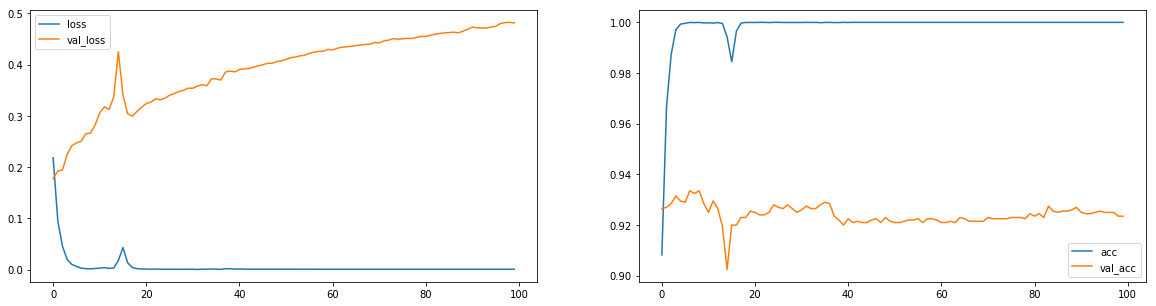

In [35]:
model_dense.fit(train_data, train_labels,
          epochs=100,
          batch_size=256,
          validation_data=(validation_data, validation_labels),
            callbacks=[PlotLosses(1, evaluate_interval=None)])